In [1]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the correct directory and filenames
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Instantiate the generator model with skip connections
def build_generator(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    # Encoder
    x1 = Conv1D(64, 15, padding='same', kernel_initializer='he_normal')(inp)
    x1 = LeakyReLU(negative_slope=0.2)(x1)

    x2 = Conv1D(128, 15, padding='same', kernel_initializer='he_normal')(x1)
    x2 = LeakyReLU(negative_slope=0.2)(x2)

    x3 = Conv1D(256, 15, padding='same', kernel_initializer='he_normal')(x2)
    x3 = LeakyReLU(negative_slope=0.2)(x3)

    x4 = Conv1D(512, 15, padding='same', kernel_initializer='he_normal')(x3)
    x4 = LeakyReLU(negative_slope=0.2)(x4)

    # Decoder with skip connections
    x5 = Conv1DTranspose(256, 15, padding='same', kernel_initializer='he_normal')(x4)
    x5 = LeakyReLU(negative_slope=0.2)(x5)
    x5 = Add()([x5, x3])

    x6 = Conv1DTranspose(128, 15, padding='same', kernel_initializer='he_normal')(x5)
    x6 = LeakyReLU(negative_slope=0.2)(x6)
    x6 = Add()([x6, x2])

    x7 = Conv1DTranspose(64, 15, padding='same', kernel_initializer='he_normal')(x6)
    x7 = LeakyReLU(negative_slope=0.2)(x7)
    x7 = Add()([x7, x1])

    out = Conv1DTranspose(1, 15, padding='same', activation='tanh')(x7)
    
    return Model(inp, out)

def denoise_signal(generator, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = generator.predict(noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # Using approximation coefficients at the highest level

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(features, labels)
    return clf

# Function to plot ECG signals
def plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices, num_samples=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Plot original ECG
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.plot(ecg_segments[i], linewidth=0.8)
        if i == 0:
            plt.title('Original ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(ecg_segments[i])])

        # Plot noisy ECG
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.plot(noisy_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title(f'Noisy ECG ({noise_name})')
        plt.ylim([-2, 2])
        plt.xlim([0, len(noisy_ecg_slices[i])])

        # Plot denoised ECG
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.plot(denoised_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title('Denoised ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(denoised_ecg_slices[i])])

    plt.tight_layout()
    plt.show()

generator = build_generator()
generator.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1

ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(mapped_labels), y=mapped_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(ecg_segments, mapped_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Add noise to ECG segments using multiple noise types and combinations
def add_combined_noise(ecg_segments, noises, target_snr_db):
    noisy_segments = []
    
    # Generate noise signal by combining all noise types
    combined_noise_signal = sum(extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noises)
    
    for ecg_segment in ecg_segments:
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Combine all noise types for collective training
all_noises = [em_noise, bw_noise, ma_noise]

# Set the SNR value
snr_db = 0  # You can adjust this value based on your needs

# Create noisy training, validation, and test datasets using all noise types combined
noisy_ecg_slices_train = add_combined_noise(X_train, all_noises, snr_db)
noisy_ecg_slices_val = add_combined_noise(X_val, all_noises, snr_db)
noisy_ecg_slices_test = add_combined_noise(X_test, all_noises, snr_db)

# Expand dimensions for training and validation
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the generator
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
clean_ecg_segments_train_expanded = np.expand_dims(X_train, axis=-1)  # Expand dims for clean ECG training data
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train the generator model on the combined noise dataset
history = generator.fit(noisy_ecg_slices_train_expanded, clean_ecg_segments_train_expanded, 
              epochs=25, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

# Dictionary to hold the noise data and names for evaluation
noises_dict = {
    'EM': [em_noise],
    'BW': [bw_noise],
    'MA': [ma_noise],
    'EM+MA': [em_noise, ma_noise],
    'EM+BW': [em_noise, bw_noise],
    'MA+BW': [ma_noise, bw_noise],
    'EM+BW+MA': [em_noise, bw_noise, ma_noise]
}

results = {}
epoch_snrs = []
epoch_rmses = []
overall_cm = np.zeros((len(class_names), len(class_names)))  # To calculate overall confusion matrix

# Evaluate the trained model on each noise type and combination
for noise_name, noise_data in noises_dict.items():
    print(f"Processing noise type: {noise_name}")
    
    noisy_ecg_slices_test = add_combined_noise(X_test, noise_data, snr_db)

    # Denoise and classify
    denoised_ecg_slices_test = denoise_signal(generator, noisy_ecg_slices_test)

    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

    test_labels = y_test[:len(features_noisy)]

    model_noisy = classify_heartbeats(features_noisy, test_labels)
    model_denoised = classify_heartbeats(features_denoised, test_labels)

    # Predict the classes
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)

    # Confusion matrix for overall metrics
    overall_cm += confusion_matrix(test_labels, predictions_denoised, labels=np.unique(test_labels))

    # Get the unique classes present in test_labels
    unique_classes = np.unique(test_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

    # Evaluate accuracy for each class
    report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

    # Store accuracy and SNR, RMSE for each class
    results[noise_name] = {
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values),
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
    }

        # Output the results for the current noise type
    print(f"Average SNR after denoising: {results['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {results['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in results['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in results['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")

    # Output the results for the current noise type
    print(f"Average SNR after denoising: {results[noise_name]['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {results[noise_name]['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in results[noise_name]['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in results[noise_name]['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")

    # Plotting for the current noise type
    plot_ecg_signals(noise_name, X_test, noisy_ecg_slices_test, denoised_ecg_slices_test)

# Overall metrics
total = np.sum(overall_cm)
accuracy = np.trace(overall_cm) / total
precision = np.diag(overall_cm) / np.sum(overall_cm, axis=0)
specificity = np.diag(overall_cm) / np.sum(overall_cm, axis=1)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {np.mean(precision):.4f}")
print(f"Overall Specificity: {np.mean(specificity):.4f}")
print(f"Overall RMSE: {np.mean(epoch_rmses):.4f}")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.show()

# Plot RMSE vs Epoch
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), epoch_rmses, label='RMSE')
plt.title('RMSE vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Plot SNR vs Epoch
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), epoch_snrs, label='SNR')
plt.title('SNR vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('SNR (dB)')
plt.legend()
plt.show()


Epoch 1/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 577s 1s/step - loss: 0.4346 - val_loss: 0.3962
Epoch 2/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - loss: 0.4215 - val_loss: 0.3800
Epoch 3/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - loss: 0.4002 - val_loss: 0.3984
Epoch 4/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - loss: 0.4108 - val_loss: 0.3601
Epoch 5/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - loss: 0.3726 - val_loss: 0.2517
Epoch 6/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 573s 1s/step - loss: 0.0826 - val_loss: 0.0437
Epoch 7/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - loss: 0.0475 - val_loss: 0.0376
Epoch 8/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - loss: 0.0407 - val_loss: 0.0425
Epoch 9/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - loss: 0.0385 - val_loss: 0.0326
Epoch 10/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - loss: 0.0379 - val_loss: 0.0295
Epoch 11/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - loss: 0.0339 - val_loss: 0.0299
Epoch 12/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 

NameError: name 'class_names' is not defined

Epoch 1/2
529/529 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - loss: 14.5712 - val_loss: 0.0557
Epoch 2/2
529/529 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - loss: 0.0539 - val_loss: 0.0410
Processing noise type: EM
114/114 ━━━━━━━━━━━━━━━━━━━━ 34s 295ms/step
Average SNR after denoising: 0.2455 dB
Average RMSE after denoising: 0.4843
Noisy data accuracies:
  N: 0.9980
  V: 0.6749
  A: 0.1538
  L: 0.8941
Denoised data accuracies:
  N: 0.9955
  V: 0.6667
  A: 0.0642
  L: 0.7533




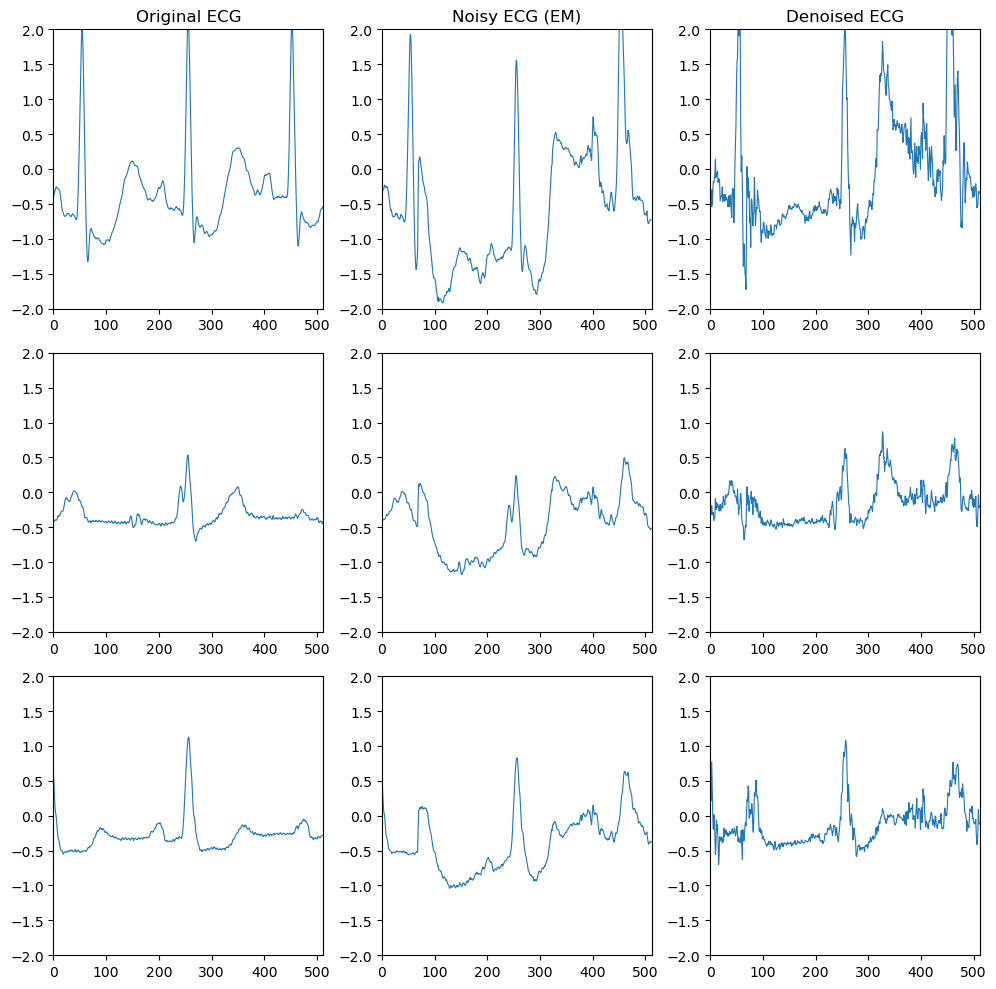

Processing noise type: BW
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 290ms/step
Average SNR after denoising: 0.6419 dB
Average RMSE after denoising: 0.2114
Noisy data accuracies:
  N: 0.9997
  V: 0.6749
  A: 0.1655
  L: 0.8957
Denoised data accuracies:
  N: 0.9955
  V: 0.5946
  A: 0.1117
  L: 0.8098




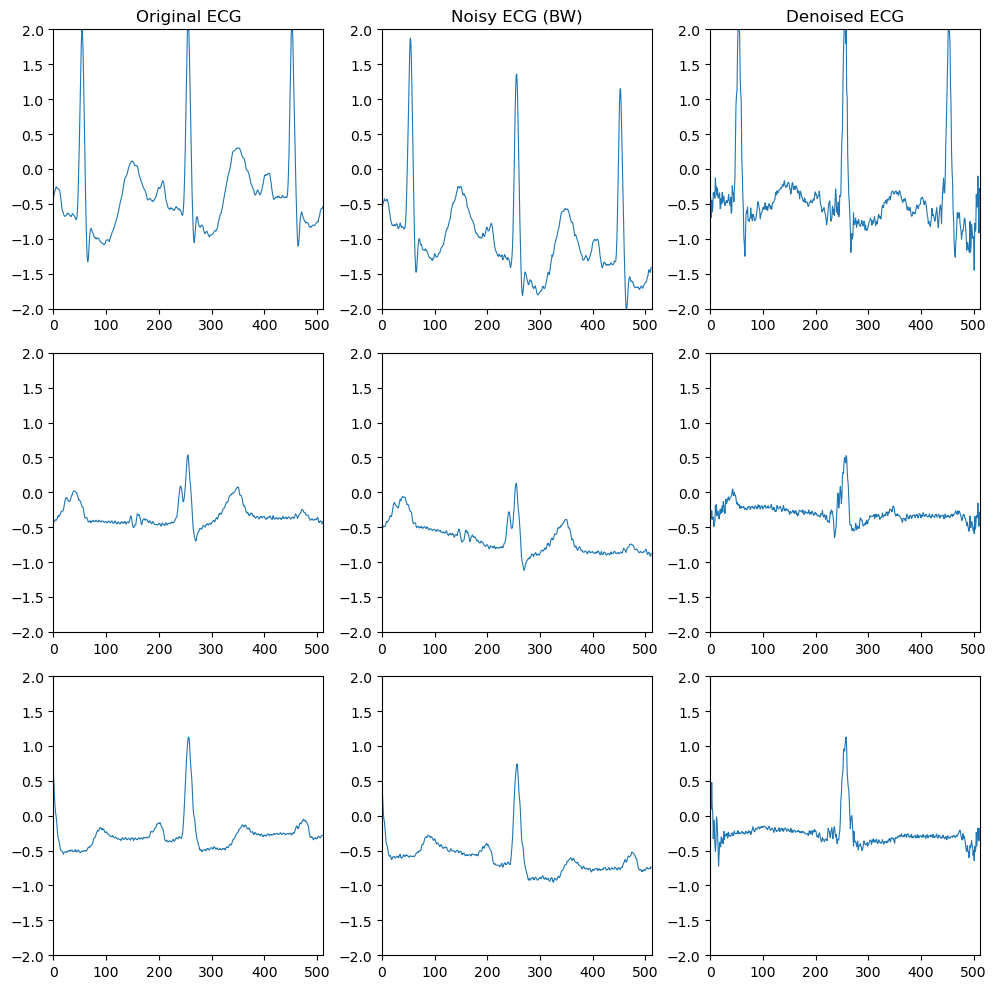

Processing noise type: MA
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 290ms/step
Average SNR after denoising: -4.3256 dB
Average RMSE after denoising: 0.9135
Noisy data accuracies:
  N: 0.9990
  V: 0.7287
  A: 0.1447
  L: 0.8985
Denoised data accuracies:
  N: 0.9927
  V: 0.4224
  A: 0.1507
  L: 0.4863




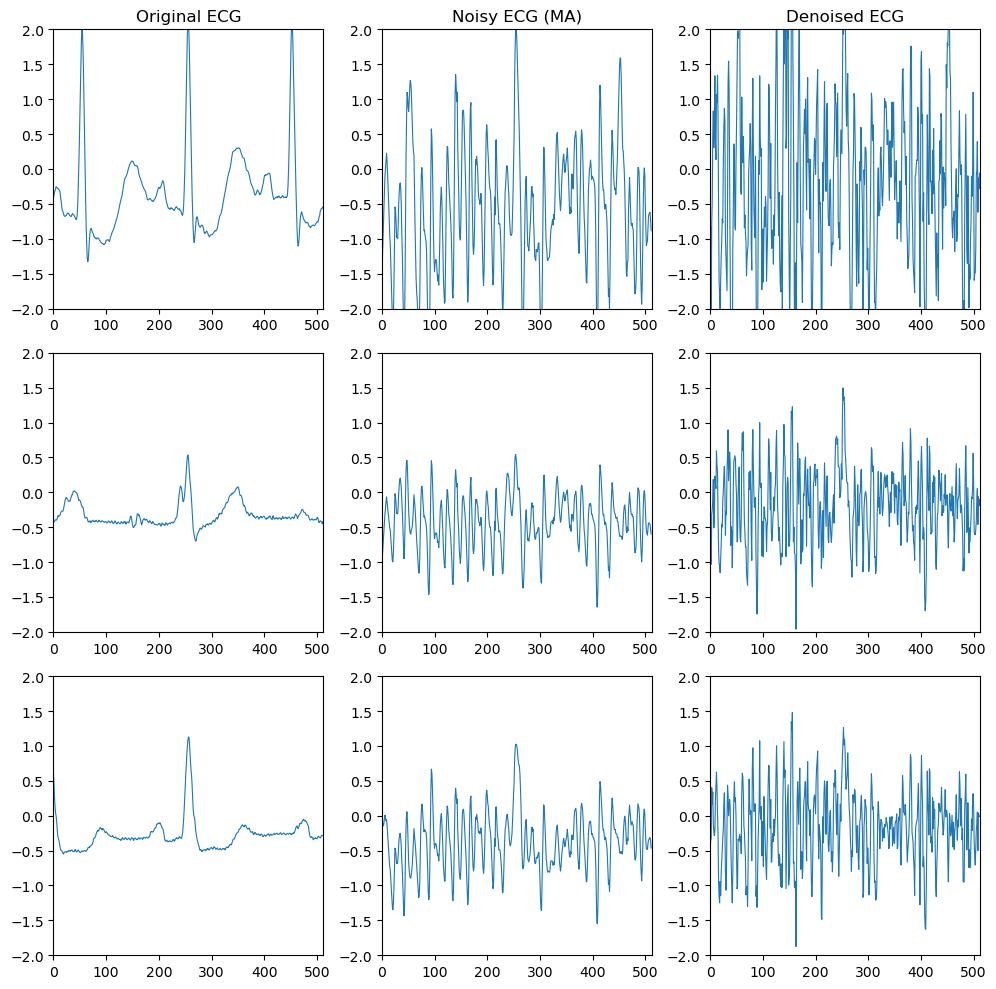

Processing noise type: EM+MA
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step
Average SNR after denoising: 0.1890 dB
Average RMSE after denoising: 0.4721
Noisy data accuracies:
  N: 0.9980
  V: 0.6749
  A: 0.1497
  L: 0.8969
Denoised data accuracies:
  N: 0.9958
  V: 0.6888
  A: 0.1192
  L: 0.7994




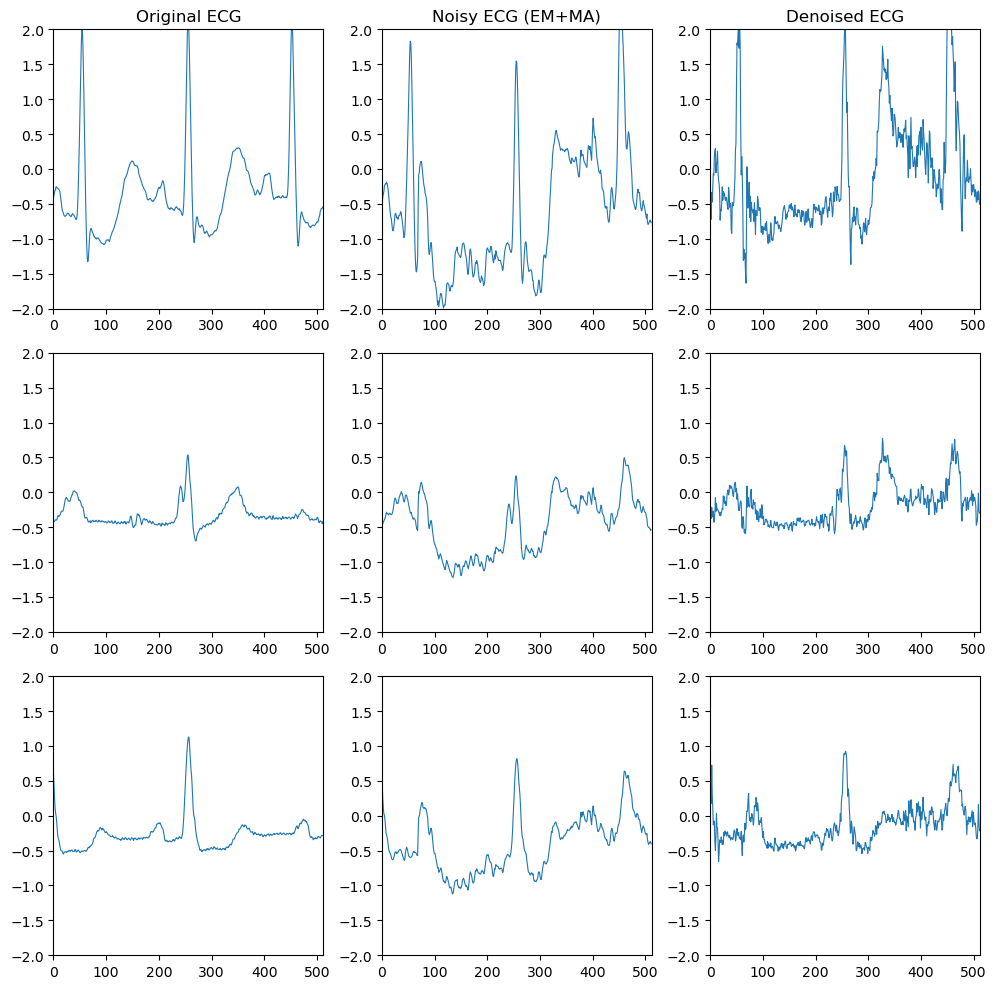

Processing noise type: EM+BW
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 291ms/step
Average SNR after denoising: 0.2851 dB
Average RMSE after denoising: 0.1877
Noisy data accuracies:
  N: 0.9993
  V: 0.6782
  A: 0.1337
  L: 0.8923
Denoised data accuracies:
  N: 0.9947
  V: 0.3872
  A: 0.0797
  L: 0.7669




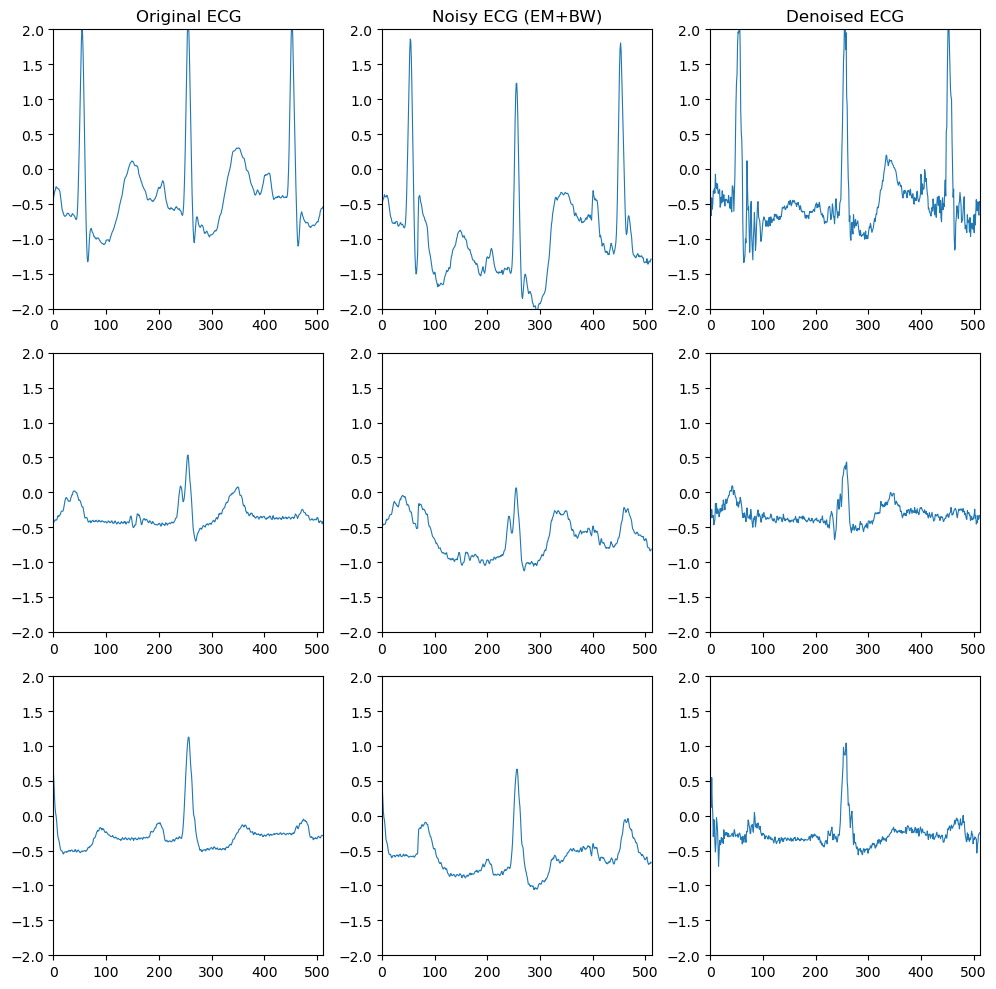

Processing noise type: MA+BW
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step
Average SNR after denoising: 0.4313 dB
Average RMSE after denoising: 0.2041
Noisy data accuracies:
  N: 0.9997
  V: 0.6749
  A: 0.1667
  L: 0.8985
Denoised data accuracies:
  N: 0.9948
  V: 0.5893
  A: 0.1447
  L: 0.8006




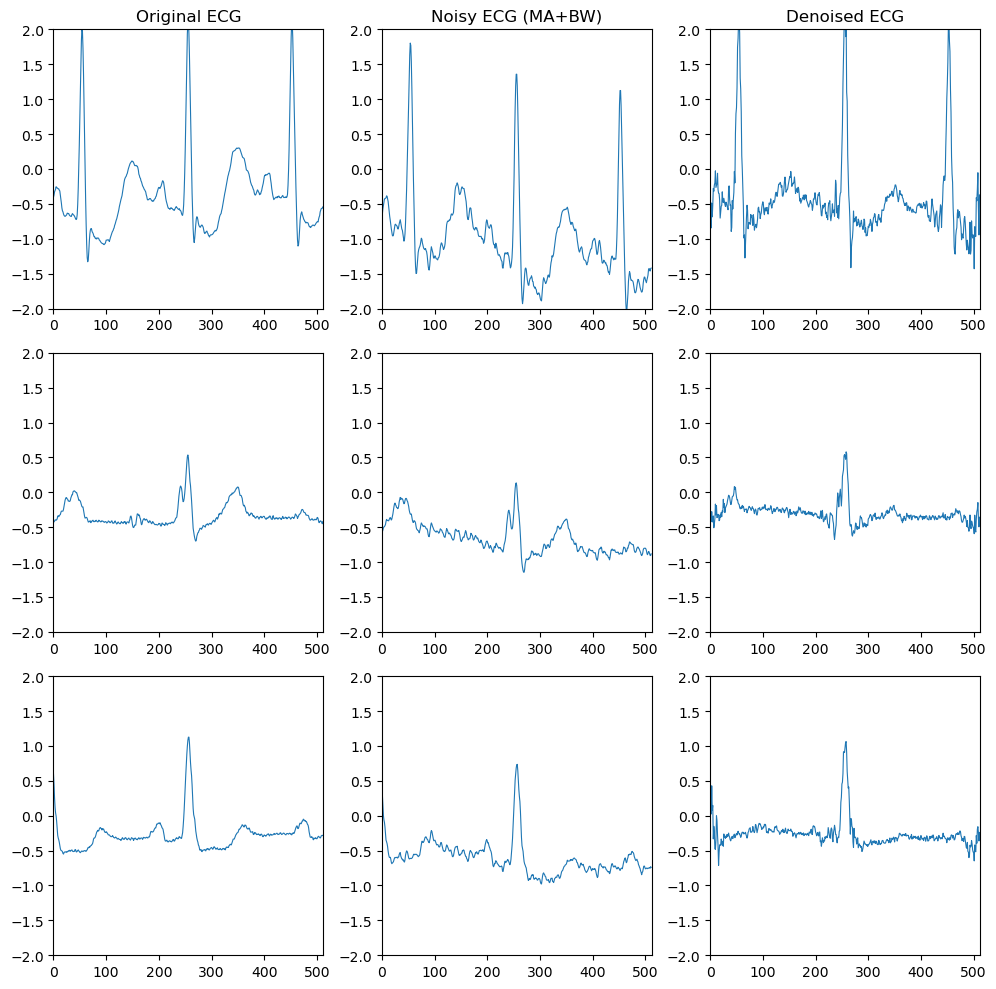

Processing noise type: EM+BW+MA
114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 290ms/step
Average SNR after denoising: 0.2452 dB
Average RMSE after denoising: 0.1835
Noisy data accuracies:
  N: 0.9993
  V: 0.6816
  A: 0.1314
  L: 0.8896
Denoised data accuracies:
  N: 0.9944
  V: 0.3728
  A: 0.0897
  L: 0.7441




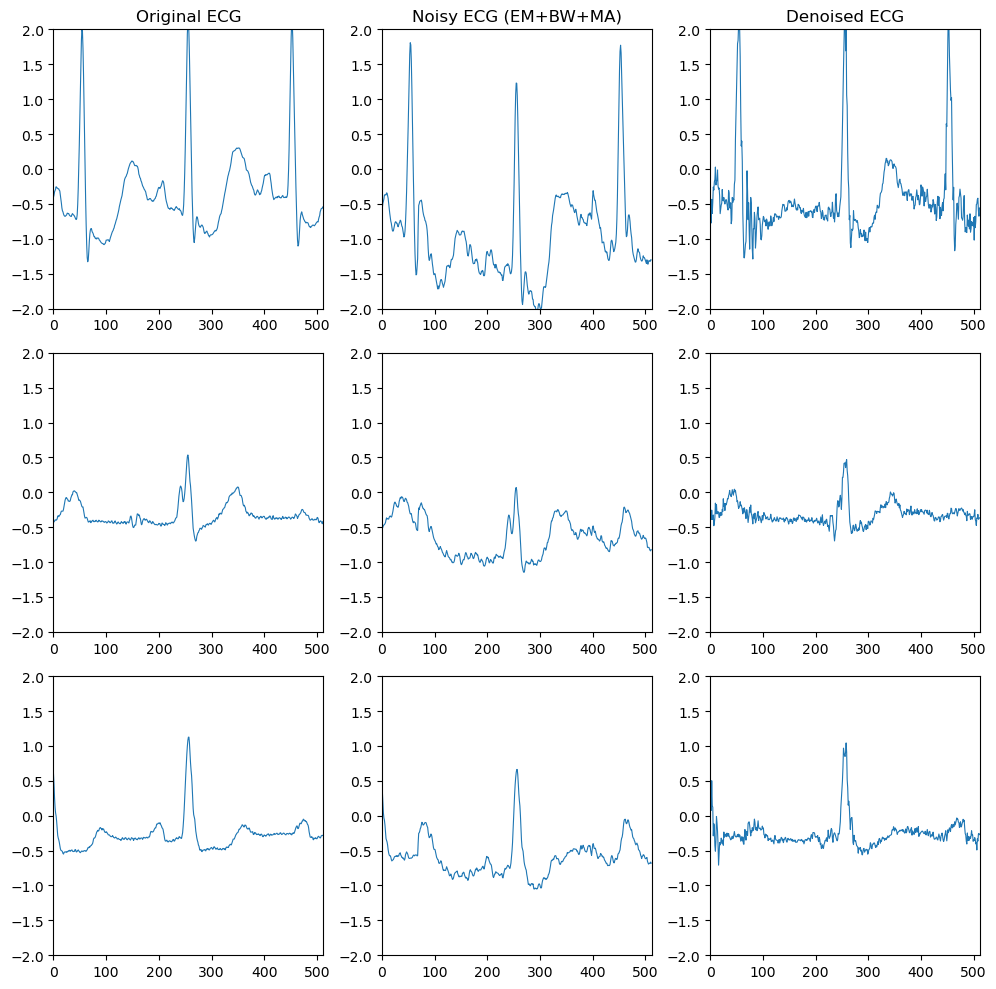

Overall Accuracy: 0.8744
Overall Precision: 0.5786
Overall Specificity: 0.9303
Overall RMSE: nan


C:\ProgramData\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


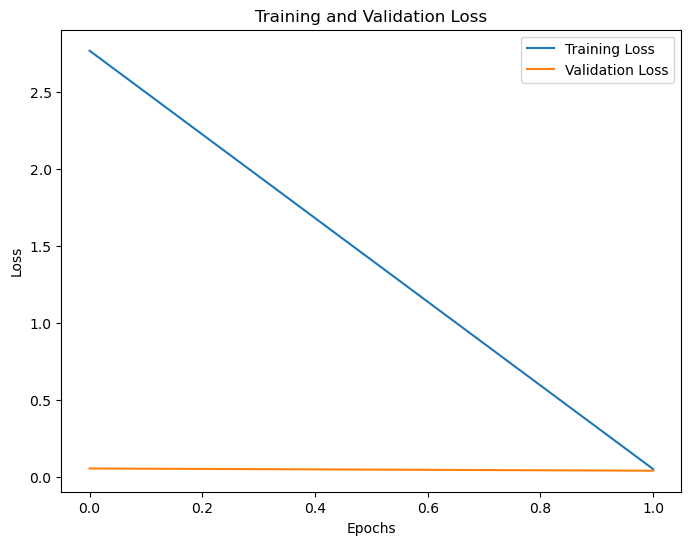

In [4]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the correct directory and filenames
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Instantiate the generator model with skip connections
def build_generator(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    # Encoder
    x1 = Conv1D(64, 15, padding='same', kernel_initializer='he_normal')(inp)
    x1 = LeakyReLU(negative_slope=0.2)(x1)

    x2 = Conv1D(128, 15, padding='same', kernel_initializer='he_normal')(x1)
    x2 = LeakyReLU(negative_slope=0.2)(x2)

    x3 = Conv1D(256, 15, padding='same', kernel_initializer='he_normal')(x2)
    x3 = LeakyReLU(negative_slope=0.2)(x3)

    x4 = Conv1D(512, 15, padding='same', kernel_initializer='he_normal')(x3)
    x4 = LeakyReLU(negative_slope=0.2)(x4)

    # Decoder with skip connections
    x5 = Conv1DTranspose(256, 15, padding='same', kernel_initializer='he_normal')(x4)
    x5 = LeakyReLU(negative_slope=0.2)(x5)
    x5 = Add()([x5, x3])

    x6 = Conv1DTranspose(128, 15, padding='same', kernel_initializer='he_normal')(x5)
    x6 = LeakyReLU(negative_slope=0.2)(x6)
    x6 = Add()([x6, x2])

    x7 = Conv1DTranspose(64, 15, padding='same', kernel_initializer='he_normal')(x6)
    x7 = LeakyReLU(negative_slope=0.2)(x7)
    x7 = Add()([x7, x1])

    out = Conv1DTranspose(1, 15, padding='same', activation='linear')(x7)
    
    return Model(inp, out)

def denoise_signal(generator, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = generator.predict(noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # Using approximation coefficients at the highest level

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(features, labels)
    return clf

# Function to plot ECG signals
def plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices, num_samples=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Plot original ECG
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.plot(ecg_segments[i], linewidth=0.8)
        if i == 0:
            plt.title('Original ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(ecg_segments[i])])

        # Plot noisy ECG
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.plot(noisy_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title(f'Noisy ECG ({noise_name})')
        plt.ylim([-2, 2])
        plt.xlim([0, len(noisy_ecg_slices[i])])

        # Plot denoised ECG
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.plot(denoised_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title('Denoised ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(denoised_ecg_slices[i])])

    plt.tight_layout()
    plt.show()

generator = build_generator()
generator.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1

ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(mapped_labels), y=mapped_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(ecg_segments, mapped_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Add noise to ECG segments using multiple noise types and combinations
def add_combined_noise(ecg_segments, noises, target_snr_db):
    noisy_segments = []
    
    # Generate noise signal by combining all noise types
    combined_noise_signal = sum(extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noises)
    
    for ecg_segment in ecg_segments:
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Combine all noise types for collective training
all_noises = [em_noise, bw_noise, ma_noise]

# Set the SNR value
snr_db = 0  # You can adjust this value based on your needs

# Create noisy training, validation, and test datasets using all noise types combined
noisy_ecg_slices_train = add_combined_noise(X_train, all_noises, snr_db)
noisy_ecg_slices_val = add_combined_noise(X_val, all_noises, snr_db)
noisy_ecg_slices_test = add_combined_noise(X_test, all_noises, snr_db)

# Expand dimensions for training and validation
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the generator
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
clean_ecg_segments_train_expanded = np.expand_dims(X_train, axis=-1)  # Expand dims for clean ECG training data
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train the generator model on the combined noise dataset
history = generator.fit(noisy_ecg_slices_train_expanded, clean_ecg_segments_train_expanded, 
              epochs=2, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

# Dictionary to hold the noise data and names for evaluation
noises_dict = {
    'EM': [em_noise],
    'BW': [bw_noise],
    'MA': [ma_noise],
    'EM+MA': [em_noise, ma_noise],
    'EM+BW': [em_noise, bw_noise],
    'MA+BW': [ma_noise, bw_noise],
    'EM+BW+MA': [em_noise, bw_noise, ma_noise]
}

results = {}
epoch_snrs = []
epoch_rmses = []

# Initialize a confusion matrix with dimensions based on the number of classes
class_names = ['N', 'V', 'A', 'L']
overall_cm = np.zeros((len(class_names), len(class_names)))  # To calculate overall confusion matrix

# Evaluate the trained model on each noise type and combination
for noise_name, noise_data in noises_dict.items():
    print(f"Processing noise type: {noise_name}")
    
    noisy_ecg_slices_test = add_combined_noise(X_test, noise_data, snr_db)

    # Denoise and classify
    denoised_ecg_slices_test = denoise_signal(generator, noisy_ecg_slices_test)

    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

    test_labels = y_test[:len(features_noisy)]

    model_noisy = classify_heartbeats(features_noisy, test_labels)
    model_denoised = classify_heartbeats(features_denoised, test_labels)

    # Predict the classes
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)

    # Confusion matrix for overall metrics
    overall_cm += confusion_matrix(test_labels, predictions_denoised, labels=np.unique(test_labels))

    # Get the unique classes present in test_labels
    unique_classes = np.unique(test_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

    # Evaluate accuracy for each class
    report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

    # Store accuracy and SNR, RMSE for each class
    results[noise_name] = {
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values),
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
    }

    # Output the results for the current noise type
    print(f"Average SNR after denoising: {results[noise_name]['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {results[noise_name]['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in results[noise_name]['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in results[noise_name]['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")

    # Plotting for the current noise type
    plot_ecg_signals(noise_name, X_test, noisy_ecg_slices_test, denoised_ecg_slices_test)

# Overall metrics
total = np.sum(overall_cm)
accuracy = np.trace(overall_cm) / total
precision = np.diag(overall_cm) / np.sum(overall_cm, axis=0)
specificity = np.diag(overall_cm) / np.sum(overall_cm, axis=1)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {np.mean(precision):.4f}")
print(f"Overall Specificity: {np.mean(specificity):.4f}")
print(f"Overall RMSE: {np.mean(epoch_rmses):.4f}")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.show()
